In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#root_path = '/content/gdrive/My Drive/Colab Notebooks/MyModel'
#import sys
#sys.path.append(root_path)
#https://github.com/huyvnphan/PyTorch-CIFAR10/blob/master/CIFAR10.ipynb

In [1]:
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.utils.data
import os
import torch.nn.functional as F
import time
import torch.distributions as td

#plots
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.ticker as ticker

#math
import numpy as np
from numpy.random import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

#modules
from cifar10_models import resnet
import data_loader
import visualize
import train_model
import FGSM
import augment
import utility

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified
Size of training set: 50000
Size of validation set: 7500
Size of test set: 2500


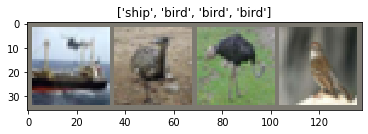

In [2]:
#LOAD DATA
batch_size=100
trainloader, validloader, testloader, attributes=data_loader.load_cifar10(batch_size, valid_ratio=.75)
N_test=attributes["N_test"]
N_train=attributes["N_train"]
N_valid = attributes["N_valid"]
classes=attributes["class_names"]
print("Size of training set: {}".format(N_train))
print("Size of validation set: {}".format(N_valid))
print("Size of test set: {}".format(N_test))
# VISUALIZE
inputs, class_data = next(iter(trainloader))
visualize.imshow(inputs[:4], title=[classes[i] for i in class_data[:4]])

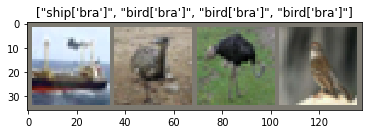

In [3]:
# TEST AUGMENTATION OF BATCH
aug_batches, aug_seqs, aug_seqs_names = augment.compute_augmentations(inputs[:4], n = 1, depth = 1, augmentations="bra")
for i, _ in enumerate(aug_seqs_names):
    visualize.imshow(aug_batches[i], title=[classes[j]+str(aug_seqs_names[i]) for j in class_data[:4]])
    plt.pause(0.001)
    
# pause a bit so that plots are updated

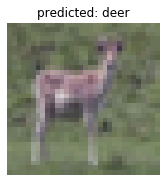

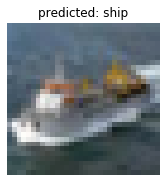

In [4]:
#load the pretrained resnet 18/34 or 50
path="cifar10_models/state_dicts/resnet18.pt"
model = resnet.resnet18(pretrained=True).to(device)
#train if necessary
#model_ft = train_model.train(model, trainloader, testloader,num_epochs=2)

model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
model.eval()
visualize.visualize_model(model, testloader, classes, num_images=2)

In [5]:
def getExamples(model, data_loader, epsilon=0.3, n=300, augmentations="r", onlybest = False):
    """
    getExamples creates three lists, one list containing the natural errors. One list containing
    correctly classified examples and a final list containing adversarial. Each entry in the list contains the following:
    [true class, [the model predicted class, model augmented predicted class], [image, augmented image], [softmax of output of model, softmax of output for augmented image]]
    """
    n_samples = n - 1
    miss_classified_examples = []
    adv_examples = []
    correct_classified_examples = []

    for data_batch, target_batch in data_loader:
        if (len(adv_examples) > n_samples) and (len(miss_classified_examples) > n_samples) and (len(correct_classified_examples) > n_samples):  # stop when we got the samples
            break

        # TODO: This loop could probably be done in a smarter way for speed up
        for original_data, original_target in zip(data_batch, target_batch):
            data = original_data.view(1, 3, 32, 32)
            # TODO: make so compute_augmentations takes all inputs, right now only accounts for flip
            augmented_batch, _, _ = augment.compute_augmentations(data.cpu(),
                                                                  n=1, depth=1, augmentations=augmentations, flip_p=1, rot=(-20.20))
            augmented_batch = augmented_batch.squeeze(0)
            # concatenate the true image and the augmented image
            data = torch.cat((data, augmented_batch), 0)
            target = torch.cat((original_target.view(1), original_target.view(1)), 0)
            
            
            data, target = data.to(device), target.to(device)

            data.requires_grad = False
            output = F.log_softmax(model(data), dim=1)
            init_pred = output.max(1, keepdim=True)[1]

            # If the initial prediction is wrong, dont bother attacking, just move on, 
            # but save the natural error example.
            if init_pred[0].item() != target[0].item():
                if len(miss_classified_examples) <= n_samples:
                    data_miss = data.detach().cpu()
                    output_miss = output.detach().cpu()
                    miss_classified_examples.append((target.detach().cpu(), 
                                                     init_pred.detach().cpu(), 
                                                     data_miss, 
                                                     output_miss.exp()))
                continue
            else:
                if len(correct_classified_examples) <= n_samples:
                    # save correct image
                    data_correct = data.detach().cpu()
                    output_correct = output.detach().cpu()
                    correct_classified_examples.append((target.detach().cpu(),
                                                        init_pred.detach().cpu(),
                                                        data_correct, 
                                                        output_correct.exp()))

            data = original_data.view(1, 3, 32, 32).to(device)
            data.requires_grad = True
            output = F.log_softmax(model(data), dim=1)
            # Call FGSM Attack
            loss = F.nll_loss(output, original_target.view(1).to(device))
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            perturbed_data = FGSM.fgsm_attack_batch(data, epsilon, data_grad)
            augmented_batch, _, _ = augment.compute_augmentations(perturbed_data.detach().cpu(),
                                                                  n=1, depth=1, augmentations=augmentations, flip_p=1, rot=(-20.20))
            
            augmented_batch = augmented_batch.squeeze(0).to(device)
            # concatenate the true image and the augmented image
            perturbed_data = torch.cat((perturbed_data, augmented_batch), 0)

            # Re-classify the perturbed image
            output_adv = F.log_softmax(model(perturbed_data), dim=1)

            # Check for successful attack
            final_pred = output_adv.max(1, keepdim=True)[1]

            # Save some adversarial examples and correct classified images
            if onlybest:
                criteria = (final_pred[0].item() != target[0].item()) and (final_pred[1].item() == target[0].item())
            else:
                criteria = (final_pred[0].item() != target[0].item())
            if criteria:
                if len(adv_examples) <= n_samples:
                    # save adversarial
                    out_adv = output_adv.detach().cpu()
                    adv_ex = perturbed_data.detach().cpu()
                    adv_examples.append((target.detach().cpu(), 
                                         final_pred.detach().cpu(), 
                                         adv_ex, out_adv.exp()))

    return correct_classified_examples, miss_classified_examples, adv_examples

In [25]:
#We use epsilon = 0.1, as the FID score is not high for this case (see lars kai mail, GOOD adversarial)
correct_classified_examples, miss_classified_examples, adv_examples = getExamples(model, testloader, epsilon = 0.3, 
                                                                                       n=500, augmentations="r")


In [26]:
_,_,images_correct,output_softmax_correct=FGSM.getOutput(correct_classified_examples)
_,_,images_miss,output_softmax_miss=FGSM.getOutput(miss_classified_examples)
_,_,images_adv,output_softmax_adv=FGSM.getOutput(adv_examples)

dkl_adv = FGSM.DKL(output_softmax_adv)
dkl_correct = FGSM.DKL(output_softmax_correct)
dkl_miss = FGSM.DKL(output_softmax_miss)

dkl_count_adv, bins_start = FGSM.DKLBin(dkl_adv, bin_size = 0.2, bin_max=10)
dkl_count_correct, bins_start = FGSM.DKLBin(dkl_correct, bin_size = 0.2, bin_max=10)
dkl_count_miss, bins_start = FGSM.DKLBin(dkl_miss, bin_size = 0.2, bin_max=10)

Text(0.5, 0, 'KL divergence')

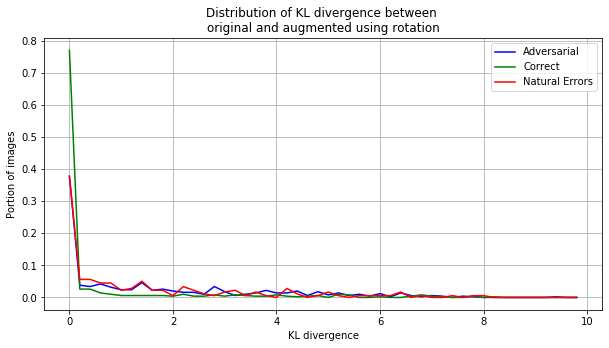

In [27]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(bins_start,dkl_count_adv,color="blue", label="Adversarial")
ax.plot(bins_start,dkl_count_correct,color="green", label="Correct")
ax.plot(bins_start,dkl_count_miss,color="red", label="Natural Errors")
leg = ax.legend(loc='upper right')
ax.set_title("Distribution of KL divergence between \noriginal and augmented using rotation")
ax.set_ylabel("Portion of images")
ax.grid(axis = "both")
ax.set_xlabel("KL divergence")

In [21]:
#We use epsilon = 0.1, as the FID score is not high for this case (see lars kai mail, GOOD adversarial)
correct_classified_examples, miss_classified_examples, adv_examples = getExamples(model, testloader, epsilon = 0.3, 
                                                                                       n=500, augmentations="flr")


In [22]:
_,_,images_correct,output_softmax_correct=FGSM.getOutput(correct_classified_examples)
_,_,images_miss,output_softmax_miss=FGSM.getOutput(miss_classified_examples)
_,_,images_adv,output_softmax_adv=FGSM.getOutput(adv_examples)

dkl_adv = FGSM.DKL(output_softmax_adv)
dkl_correct = FGSM.DKL(output_softmax_correct)
dkl_miss = FGSM.DKL(output_softmax_miss)

dkl_count_adv, bins_start = FGSM.DKLBin(dkl_adv, bin_size = 0.2, bin_max=10)
dkl_count_correct, bins_start = FGSM.DKLBin(dkl_correct, bin_size = 0.2, bin_max=10)
dkl_count_miss, bins_start = FGSM.DKLBin(dkl_miss, bin_size = 0.2, bin_max=10)

Text(0.5, 0, 'KL divergence')

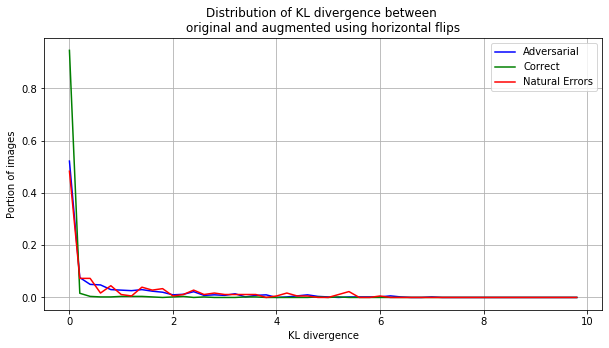

In [23]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(bins_start,dkl_count_adv,color="blue", label="Adversarial")
ax.plot(bins_start,dkl_count_correct,color="green", label="Correct")
ax.plot(bins_start,dkl_count_miss,color="red", label="Natural Errors")
leg = ax.legend(loc='upper right')
ax.set_title("Distribution of KL divergence between \noriginal and augmented using horizontal flips")
ax.set_ylabel("Portion of images")
ax.grid(axis = "both")
ax.set_xlabel("KL divergence")

Text(0.5, 0, 'KL divergence')

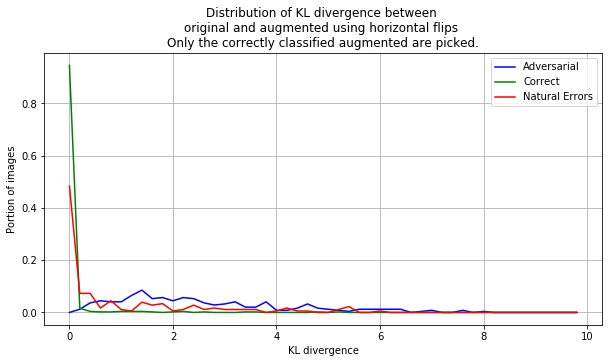

In [24]:
#We use epsilon = 0.1, as the FID score is not high for this case (see lars kai mail, GOOD adversarial)
correct_classified_examples, miss_classified_examples, adv_examples = getExamples(model, testloader, epsilon = 0.3, 
                                                                                       n=500, augmentations="flr", onlybest = True)

_,_,images_correct,output_softmax_correct=FGSM.getOutput(correct_classified_examples)
_,_,images_miss,output_softmax_miss=FGSM.getOutput(miss_classified_examples)
_,_,images_adv,output_softmax_adv=FGSM.getOutput(adv_examples)

dkl_adv = FGSM.DKL(output_softmax_adv)
dkl_correct = FGSM.DKL(output_softmax_correct)
dkl_miss = FGSM.DKL(output_softmax_miss)

dkl_count_adv, bins_start = FGSM.DKLBin(dkl_adv, bin_size = 0.2, bin_max=10)
dkl_count_correct, bins_start = FGSM.DKLBin(dkl_correct, bin_size = 0.2, bin_max=10)
dkl_count_miss, bins_start = FGSM.DKLBin(dkl_miss, bin_size = 0.2, bin_max=10)

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(bins_start,dkl_count_adv,color="blue", label="Adversarial")
ax.plot(bins_start,dkl_count_correct,color="green", label="Correct")
ax.plot(bins_start,dkl_count_miss,color="red", label="Natural Errors")
leg = ax.legend(loc='upper right')
ax.set_title("Distribution of KL divergence between \noriginal and augmented using horizontal flips \nOnly the correctly classified augmented are picked.")
ax.set_ylabel("Portion of images")
ax.grid(axis = "both")
ax.set_xlabel("KL divergence")

Text(0.5, 0, 'KL divergence')

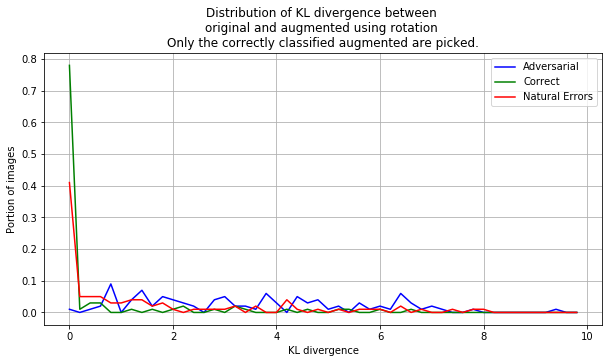

In [13]:
#We use epsilon = 0.1, as the FID score is not high for this case (see lars kai mail, GOOD adversarial)
correct_classified_examples, miss_classified_examples, adv_examples = getExamples(model, testloader, epsilon = 0.3, 
                                                                                       n=100, augmentations="r", onlybest = True)

_,_,images_correct,output_softmax_correct=FGSM.getOutput(correct_classified_examples)
_,_,images_miss,output_softmax_miss=FGSM.getOutput(miss_classified_examples)
_,_,images_adv,output_softmax_adv=FGSM.getOutput(adv_examples)

dkl_adv = FGSM.DKL(output_softmax_adv)
dkl_correct = FGSM.DKL(output_softmax_correct)
dkl_miss = FGSM.DKL(output_softmax_miss)

dkl_count_adv, bins_start = FGSM.DKLBin(dkl_adv, bin_size = 0.2, bin_max=10)
dkl_count_correct, bins_start = FGSM.DKLBin(dkl_correct, bin_size = 0.2, bin_max=10)
dkl_count_miss, bins_start = FGSM.DKLBin(dkl_miss, bin_size = 0.2, bin_max=10)

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(bins_start,dkl_count_adv,color="blue", label="Adversarial")
ax.plot(bins_start,dkl_count_correct,color="green", label="Correct")
ax.plot(bins_start,dkl_count_miss,color="red", label="Natural Errors")
leg = ax.legend(loc='upper right')
ax.set_title("Distribution of KL divergence between \noriginal and augmented using rotation \nOnly the correctly classified augmented are picked.")
ax.set_ylabel("Portion of images")
ax.grid(axis = "both")
ax.set_xlabel("KL divergence")

Text(0.5, 0, 'KL divergence')

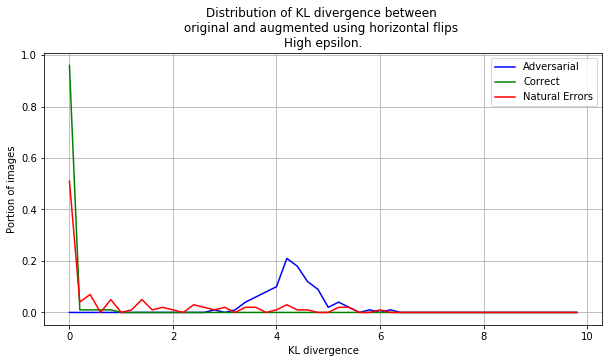

In [14]:
#We use epsilon = 0.1, as the FID score is not high for this case (see lars kai mail, GOOD adversarial)
correct_classified_examples, miss_classified_examples, adv_examples = getExamples(model, testloader, epsilon = 10, 
                                                                                       n=100, augmentations="flr", onlybest = False)

_,_,images_correct,output_softmax_correct=FGSM.getOutput(correct_classified_examples)
_,_,images_miss,output_softmax_miss=FGSM.getOutput(miss_classified_examples)
_,_,images_adv,output_softmax_adv=FGSM.getOutput(adv_examples)

dkl_adv = FGSM.DKL(output_softmax_adv)
dkl_correct = FGSM.DKL(output_softmax_correct)
dkl_miss = FGSM.DKL(output_softmax_miss)

dkl_count_adv, bins_start = FGSM.DKLBin(dkl_adv, bin_size = 0.2, bin_max=10)
dkl_count_correct, bins_start = FGSM.DKLBin(dkl_correct, bin_size = 0.2, bin_max=10)
dkl_count_miss, bins_start = FGSM.DKLBin(dkl_miss, bin_size = 0.2, bin_max=10)

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(bins_start,dkl_count_adv,color="blue", label="Adversarial")
ax.plot(bins_start,dkl_count_correct,color="green", label="Correct")
ax.plot(bins_start,dkl_count_miss,color="red", label="Natural Errors")
leg = ax.legend(loc='upper right')
ax.set_title("Distribution of KL divergence between \noriginal and augmented using horizontal flips \nHigh epsilon.")
ax.set_ylabel("Portion of images")
ax.grid(axis = "both")
ax.set_xlabel("KL divergence")

In [180]:
np.mean(dkl_miss)

1.2495561

In [181]:
np.mean(dkl_correct)

0.062161252

In [182]:
np.mean(dkl_adv)

2.7833798

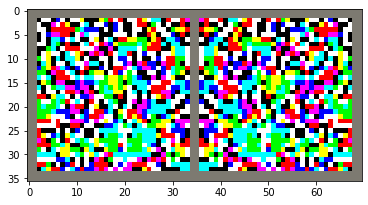

In [15]:
visualize.imshow(images_adv[2])

## FGSM

In [184]:
augmentations_list = ["none","g", "r", "flr", "bra", "r,flr,bra", "g,r,flr,bra"]
n_augs = [2,5,10,20,40]
epsilons = [0,0.1,0.2, 0.3]

results = []

for aug in augmentations_list:
    for n in n_augs:
        for epsilon in epsilons:
            final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug,
                                                                             n = n)
            #some statistics if necessary
            pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
            #get ece and bins
            ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
            #plot it
            if aug == "none":
                title = "Reliability Diagram No Augmentations\nEpsilon: {}".format(epsilon)
            else:
                title = "Reliability Diagram Augmentations: {}\nEpsilon: {} A: {}".format(aug, epsilon,n)
            fig = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)
            results.append({"augments":aug,"n":n,"epsilon":epsilon,"accuracy":final_acc,"ece":ece,"figure":fig})
            plt.figure(fig.number)
            plt.savefig("plots/reliability_diagram_n{}_aug-{}_epsilon{}.png".format(n,aug.replace(",","-"),epsilon))

20%
40%
60%
80%


KeyboardInterrupt: 

In [185]:
import pandas as pd
import pickle

#df = pd.DataFrame(results)
#df.to_pickle("results_20200409.pandaspickle")
#df.head(140)

""


In [17]:
df.to_csv("results_20200409.csv")

In [204]:
n = 1
epsilon = 0
aug = "none"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug, n = n)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 7002 / 7500 = 0.9336


Expected Calibration Error: 0.04340152069926262


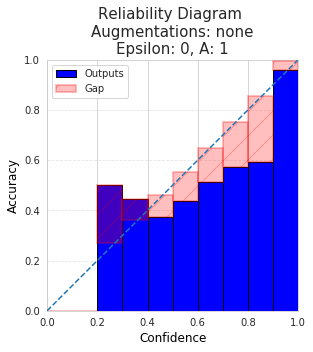

In [205]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, A: {}".format(aug, epsilon,n)
figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)

plt.figure(figure.number)


print("Expected Calibration Error: {}".format(ece))


In [193]:
n = 1
epsilon = 0
aug = "g"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug, n = n)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 4730 / 7500 = 0.6306666666666667


In [202]:
n = 1
epsilon = 0.3
aug = "none"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug, n = n)

20%
40%
60%
80%
100%
Epsilon: 0.3	Test Accuracy = 2155 / 7500 = 0.28733333333333333


Expected Calibration Error: 0.5995093584060669


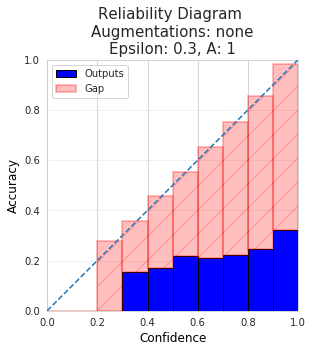

In [203]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, A: {}".format(aug, epsilon,n)
figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)

plt.figure(figure.number)


print("Expected Calibration Error: {}".format(ece))


In [198]:
n = 1
epsilon = 0
aug = "fliplr"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=0,
                                                                             augmentations = aug, n = 1)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 7001 / 7500 = 0.9334666666666667


Expected Calibration Error: 0.043779805302619934


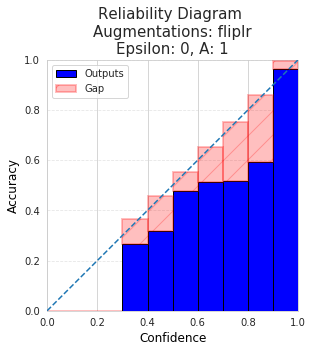

In [199]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, A: {}".format(aug, epsilon,n)
figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)

plt.figure(figure.number)


print("Expected Calibration Error: {}".format(ece))


In [200]:
n = 1
epsilon = 0.3
aug = "fliplr"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug, n = n)

20%
40%
60%
80%
100%
Epsilon: 0.3	Test Accuracy = 2401 / 7500 = 0.3201333333333333


Expected Calibration Error: 0.5644220113754272


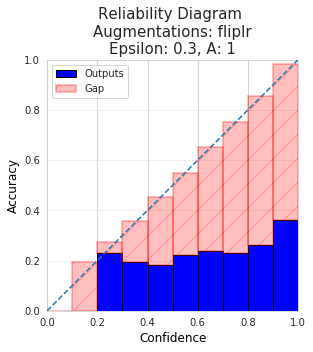

In [201]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, A: {}".format(aug, epsilon,n)
figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)

plt.figure(figure.number)


print("Expected Calibration Error: {}".format(ece))


In [22]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, testloader, mode="mode", epsilon=0, augmentations = "r,flr,bra", n = 21, v = 1)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 2348 / 2500 = 0.9392


In [16]:
n = 1
epsilon = 0
aug = "none"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=0.05,
                                                                             augmentations = aug, n = 1)

20%
40%
60%
80%
100%
Epsilon: 0.05	Test Accuracy = 4393 / 7500 = 0.5857333333333333


In [17]:
n = 1
epsilon = 0
aug = "none"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=0.1,
                                                                             augmentations = aug, n = 1)

20%
40%
60%
80%
100%
Epsilon: 0.1	Test Accuracy = 3538 / 7500 = 0.47173333333333334


In [18]:
n = 1
epsilon = 0
aug = "none"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=0.5,
                                                                             augmentations = aug, n = 1)

20%
40%
60%
80%
100%
Epsilon: 0.5	Test Accuracy = 1230 / 7500 = 0.164


In [19]:
n = 1
epsilon = 0
aug = "none"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=1,
                                                                             augmentations = aug, n = 1)

20%
40%
60%
80%
100%
Epsilon: 1	Test Accuracy = 773 / 7500 = 0.10306666666666667


In [20]:
n = 1
epsilon = 0
aug = "none"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=10,
                                                                             augmentations = aug, n = 1)

20%
40%
60%
80%
100%
Epsilon: 10	Test Accuracy = 749 / 7500 = 0.09986666666666667


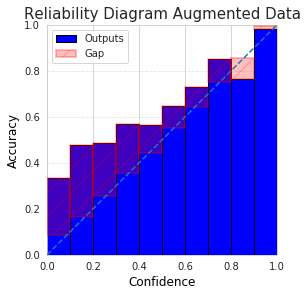

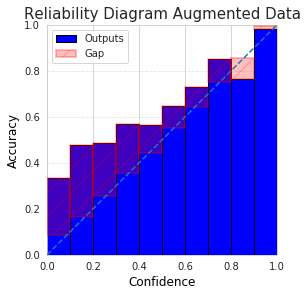

In [23]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram Augmented Data")

In [17]:
final_acc_adv, adv_examples_adv, pred_log_probs_adv, target_labels_adv = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "r,flr,bra", n = 21, v = 1)

20%
40%
60%
80%
100%
Epsilon: 0.3	Test Accuracy = 923 / 2500 = 0.3692


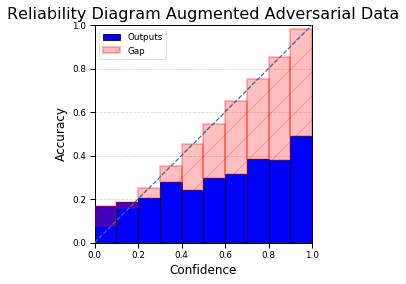

In [18]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs_adv)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels_adv, pred_log_probs_adv)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram Augmented Adversarial Data")


In [19]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "r,flr,bra", n = 5, v = 1)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 2364 / 2500 = 0.9456


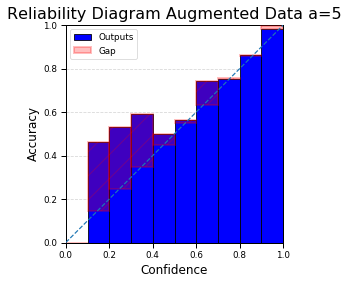

In [20]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram Augmented Data a=5")

In [21]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "r,flr,bra", n = 50, v = 1)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 2376 / 2500 = 0.9504


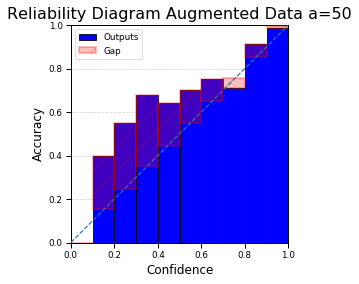

In [22]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram Augmented Data a=50")

In [25]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "r,flr,bra", n = 2, v = 1)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 2360 / 2500 = 0.944


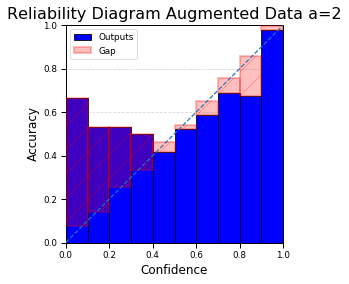

In [26]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram Augmented Data a=2")

# FID

In [ ]:
n_batches = 2
inputs_arr = []
iter_dataloader = iter(trainloader)
for _ in range(n_batches):
    cur_inputs, c =  next(iter_dataloader)
    inputs_arr.append(cur_inputs)
    
inputs = torch.cat(inputs_arr, dim = 0)
inputs.shape

In [ ]:
model_features, p = utility.get_features(model)

In [ ]:
params = [0,5,10,15]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="g", noise_level=params, bottleneck=True)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with Gaussian noise")

In [5]:
params = [0,5,7,12,25]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="r", noise_level=params, bottleneck = True)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with rotation", xlabel="Degrees")

torch.Size([200, 3, 32, 32])

In [6]:
model_features, p = utility.get_features(model)

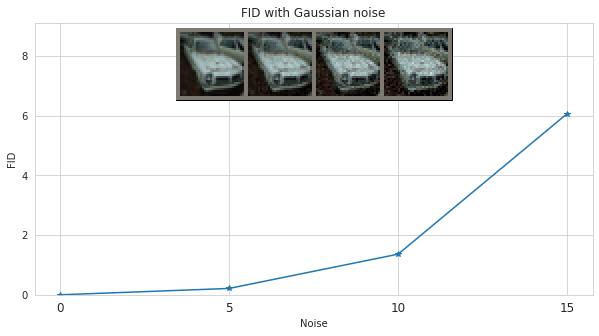

In [7]:
params = [0,5,10,15]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="g", noise_level=params, bottleneck=True)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with Gaussian noise")

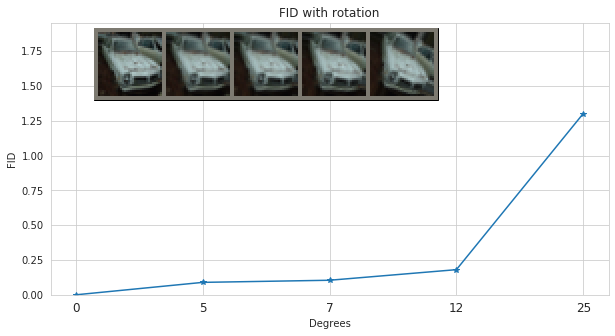

In [8]:
params = [0,5,7,12,25]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="r", noise_level=params, bottleneck = True)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with rotation", xlabel="Degrees")

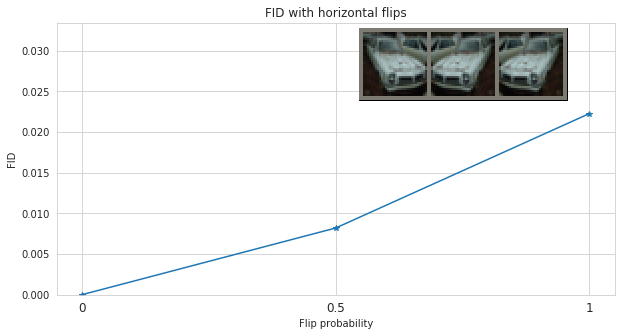

In [9]:
params = [0,0.5,1]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="flr", noise_level=params, bottleneck = True)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with horizontal flips", xlabel="Flip probability")

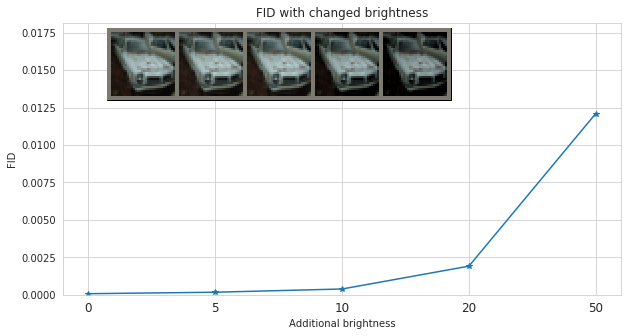

In [12]:
params = [0,5,10,20,50]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="bra", noise_level=params, bottleneck = True)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with changed brightness", xlabel="Additional brightness")